# Statistical analysis - experiment 2 

### Import the libraries 

In [1]:
import os
import numpy as np
import pandas as pd
from csv import reader
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all csv-files in the folder

In [2]:
def list_csv_files(resultsdir):
    csv_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.csv'):
                    if all('' == s for s in subdir):
                        csv_files.append(name)
                    else:
                        csv_files.append(os.path.join(subdirname, name))
    
        csv_files.sort()

    return csv_files

### Function to get all unique combinations

In [3]:
def get_unique_combinations(csv_files):
    unique_combinations = []
    for c in range(len(csv_files)):
        csv_file = csv_files[c]
        splits = csv_file.split("/")
        run_no = splits[0].split("run")[-1]
        sam_mt = splits[1].split("_")[0]
        unc_mt = splits[1].split("_")[1]
        prob = splits[1].split("_")[2]
        fwp = splits[1].split("_")[3]
        sam_sz = splits[1].split("_")[4]
        
        if unc_mt == 'mean':
            unc_mt = 'average'
        
        unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
        unique_combinations.append(unique_combination)
    return list(set(unique_combinations))

### Load the csv-files and store the data in a pandas-dataframe 

In [4]:
resultsdir = "results/exp2"
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
csv_files = list_csv_files(resultsdir)

clmns = ["sampling_method", "uncertainty_method", "dropout_probability", "number_forward_passes", "sampling_size", "unique_combination", "run", "number_images", "mAP"]
df = pd.DataFrame(columns=clmns)
unique_combinations = get_unique_combinations(csv_files)
ucs = [None] * len(unique_combinations)

for c in range(len(csv_files)):
    csv_file = csv_files[c]
    splits = csv_file.split("/")
    run_no = splits[0].split("run")[-1]
    sam_mt = splits[1].split("_")[0]
    unc_mt = splits[1].split("_")[1]
    prob = splits[1].split("_")[2]
    fwp = splits[1].split("_")[3]
    sam_sz = splits[1].split("_")[4]
    
    if unc_mt == 'mean':
        unc_mt = 'average'
        
    unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
    uc_id = unique_combinations.index(unique_combination) 
    ucs[uc_id] = unique_combination

    with open(os.path.join(resultsdir, csv_file), 'r') as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            data = [sam_mt, unc_mt, float(prob), int(fwp), int(sam_sz), int(uc_id), int(run_no), int(row[0]), float(row[1])]
            df.loc[len(df)] = data
            
df

,sampling_method,uncertainty_method,dropout_probability,number_forward_passes,sampling_size,unique_combination,run,number_images,mAP
0,uncertainty,average,0.25,20,200,0,1,100,19.5
1,uncertainty,average,0.25,20,200,0,1,300,34.3
2,uncertainty,average,0.25,20,200,0,1,500,41.4
3,uncertainty,average,0.25,20,200,0,1,700,46.5
4,uncertainty,average,0.25,20,200,0,1,900,45.4
...,...,...,...,...,...,...,...,...,...
775,uncertainty,min,0.75,40,200,11,5,1700,51.7
776,uncertainty,min,0.75,40,200,11,5,1900,52.9
777,uncertainty,min,0.75,40,200,11,5,2100,52.9
778,uncertainty,min,0.75,40,200,11,5,2300,57.9


### Plot the performance for each of the combinations

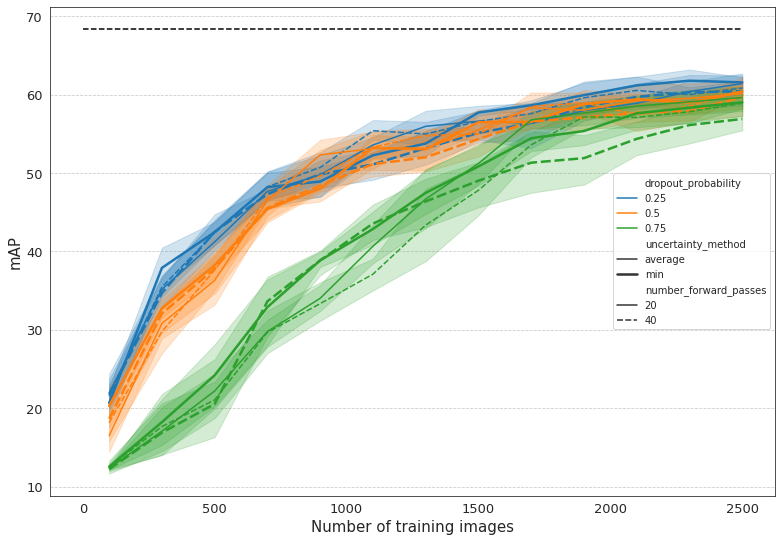

In [7]:
font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("whitegrid")
sns.set_style("white")
f, ax = plt.subplots(figsize=(13, 9))
# ax = sns.lineplot(x="number_images", y="mAP", style="number_forward_passes", hue="dropout_probability", size="uncertainty_method", sizes=[1.5, 2.5], err_style="bars", ci=95, data=df, palette = "tab10")
ax = sns.lineplot(x="number_images", y="mAP", style="number_forward_passes", hue="dropout_probability", size="uncertainty_method", sizes=[1.5, 2.5], ci=95, data=df, palette = "tab10")
#ax = sns.lineplot(x="number_images", y="mAP", hue="number_forward_passes", style="dropout_probability", err_style="bars", ci=95, data=df, palette = "tab10")
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(labelrotation=0, labelsize=digit_size)

plt.xlabel('Number of training images', fontsize=font_size)
plt.ylabel('mAP', fontsize=font_size)
plt.legend(loc='center right')
plt.hlines(68.4, 0, 2500, colors='k', linestyles='dashed', label='maximum performance (on 14.000 images)')
plt.savefig('/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Results/exp2/exp2.png')
plt.show()

### ANOVA with repeated measures 

In [6]:
## one-way ANOVA on the unique_combination with repeated measures on the runs
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['unique_combination'], aggregate_func='mean')

## two-way ANOVA on the unique_combination and the number_images with repeated measures on the runs
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['unique_combination', 'number_images'])

## two-way ANOVA on the dropout_probability and the number_forward_passes with repeated measures on the runs
# mean = df.groupby(['dropout_probability', 'number_forward_passes']).mean()
# var = df.groupby(['dropout_probability', 'number_forward_passes']).var()
# aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes'], aggregate_func='mean')

## three-way ANOVA on the dropout_probability and the number_forward_passes with repeated measures on the runs
mean = df.groupby(['dropout_probability', 'number_forward_passes', 'uncertainty_method']).mean()
var = df.groupby(['dropout_probability', 'number_forward_passes', 'uncertainty_method']).var()
mean1 = df.groupby(['dropout_probability']).mean()
mean2 = df.groupby(['number_forward_passes']).mean()
mean3 = df.groupby(['uncertainty_method']).mean()
var1 = df.groupby(['dropout_probability']).var()
var2 = df.groupby(['number_forward_passes']).var()
var3 = df.groupby(['uncertainty_method']).var()
aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes', 'uncertainty_method'], aggregate_func='mean')

res = aovrm.fit()
print(mean)
# print(var)
print(mean1)
print(mean2)
print(mean3)
# print(var1)
# print(var2)
# print(var3)
print(res)

                                                                    mAP
dropout_probability number_forward_passes uncertainty_method           
0.25                20                    average             50.535385
                                          min                 51.152308
                    40                    average             51.063077
                                          min                 50.052308
0.50                20                    average             49.187692
                                          min                 49.350769
                    40                    average             49.150769
                                          min                 48.380000
0.75                20                    average             41.975385
                                          min                 42.513846
                    40                    average             40.546154
                                          min                 40

In [7]:
do_25 = df[df["dropout_probability"] == 0.25]

## two-way ANOVA on the number_forward_passes and the uncertainty_method with repeated measures on the runs
mean = do_25.groupby(['number_forward_passes', 'uncertainty_method']).mean()
var = do_25.groupby(['number_forward_passes', 'uncertainty_method']).var()
aovrm = AnovaRM(data=do_25, depvar='mAP', subject='run', within=['number_forward_passes', 'uncertainty_method'], aggregate_func='mean')

res = aovrm.fit()
print(mean)
print(var)
print(res)

                                          dropout_probability        mAP
number_forward_passes uncertainty_method                                
20                    average                            0.25  50.535385
                      min                                0.25  51.152308
40                    average                            0.25  51.063077
                      min                                0.25  50.052308
                                          dropout_probability         mAP
number_forward_passes uncertainty_method                                 
20                    average                             0.0  130.002947
                      min                                 0.0  135.934721
40                    average                             0.0  131.809240
                      min                                 0.0  126.150659
                                Anova
                                         F Value Num DF Den DF Pr > F
----------

### Prepare the data

In [8]:
uc = df.groupby(['unique_combination', 'run']).mean().reset_index()
uc_print = uc.groupby(['unique_combination']).mean().drop(columns=['run', 'dropout_probability'])
uc_print.insert(0, "dropout_probability", [ucs[u].split("_")[2] for u in range(len(ucs))], True)
uc_print.insert(1, "uncertainty_method", [ucs[u].split("_")[1] for u in range(len(ucs))], True)
uc_print.insert(2, "number_forward_passes", [ucs[u].split("_")[3] for u in range(len(ucs))], True)
ucf = uc_print.sort_values(by='mAP', ascending=False)
ucf

,dropout_probability,uncertainty_method,number_forward_passes,mAP
unique_combination,,,,
5,0.25,min,20,51.152308
0,0.25,average,40,51.063077
6,0.25,average,20,50.535385
2,0.25,min,40,50.052308
3,0.50,min,20,49.350769
7,0.50,average,20,49.187692
10,0.50,average,40,49.150769
4,0.50,min,40,48.380000
1,0.75,min,20,42.513846


### ANOVA table and LSD calculation

In [9]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/interactions_anova.html#Two-way-ANOVA
# https://www.statology.org/fishers-least-significant-difference/
# https://personal.utdallas.edu/~herve/abdi-LSD2010-pretty.pdf
# https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# https://www.youtube.com/watch?v=ZRX4lFtMboo

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

nosum_lm = ols("mAP ~ C(unique_combination)", data=uc).fit()
an = anova_lm(nosum_lm)
print(an)

runs = 5
t = stats.t.ppf(1-0.025, an.df.Residual)
LSD = t * np.sqrt(an.mean_sq.Residual * (1/runs + 1/runs))
print("Least Significant Difference: {:.2f}".format(LSD))

                         df      sum_sq    mean_sq          F        PR(>F)
C(unique_combination)  11.0  982.941021  89.358275  41.175186  1.171044e-20
Residual               48.0  104.169467   2.170197        NaN           NaN
Least Significant Difference: 1.87


### Boxplot

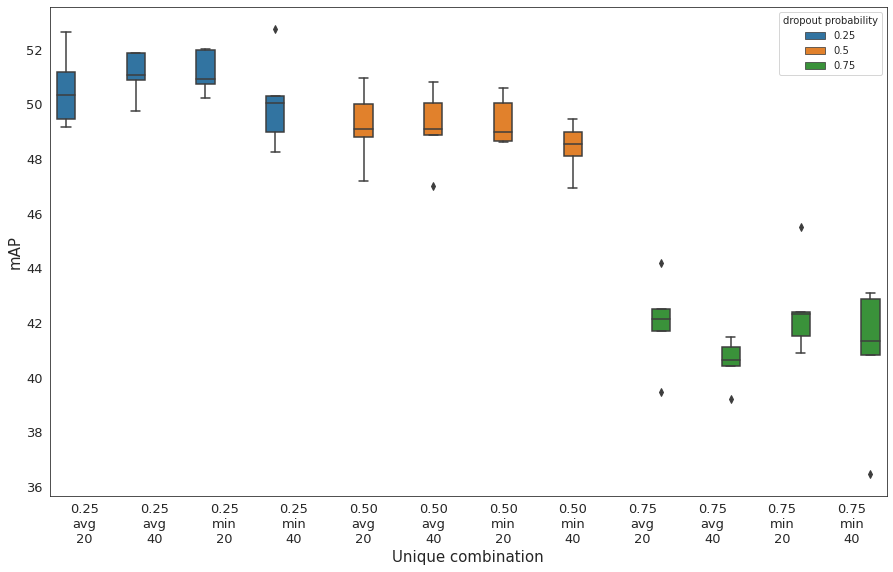

In [10]:
font_size = 15
digit_size = 13
annot_size = 14

xt = []

for u in range(len(ucs)):
    do = ucs[u].split("_")[2]
    um = ucs[u].split("_")[1]
    fp = ucs[u].split("_")[3]
    
    if um == "average":
        um = "avg"
    
    xt.append(do + "_" + um + "_" + fp)

xt.sort()

order = []
xticks = []

for x in range(len(xt)):
    do = xt[x].split("_")[0]
    um = xt[x].split("_")[1]
    fp = xt[x].split("_")[2]
    
    for u in range(len(ucs)):
        doc = ucs[u].split("_")[2]
        umc = ucs[u].split("_")[1]
        fpc = ucs[u].split("_")[3]
        
        if umc == "average":
            umc = "avg"
        
        if do == doc and um == umc and fp == fpc:
            xticks.append(doc + "\n" + umc + "\n" + fpc)
            uc_id = ucs.index(ucs[u])
            order.append(uc_id)

sns.set_style("whitegrid")
sns.set_style("white")
f, ax = plt.subplots(figsize=(15, 9))
ax = sns.boxplot(x="unique_combination", y="mAP", hue="dropout_probability", data=uc, order=order)
ax.tick_params(labelrotation=0, labelsize=digit_size)
plt.xticks(np.arange(len(ucs)), xticks)

plt.xlabel('Unique combination', fontsize=font_size)
plt.ylabel('mAP', fontsize=font_size)
plt.legend(loc='upper right', title="dropout probability")
plt.show()